In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

## Standard Statsmodels import
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## fixing random for lesson generation
np.random.seed(321)

## load data
df = pd.read_csv('Data/tmdb_results_combined.csv.gz')
df.head()

adult                     backdrop_path belongs_to_collection      budget  \
0    NaN                               NaN                   NaN         NaN   
1    0.0  /vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg                   NaN  10000000.0   
2    0.0                               NaN                   NaN         0.0   
3    0.0                               NaN                   NaN         0.0   
4    0.0  /n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg                   NaN    150000.0   

                                              genres  \
0                                                NaN   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...   
2           [{'id': 878, 'name': 'Science Fiction'}]   
3  [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...   
4  [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...   

                               homepage        id original_language  \
0                                   NaN       NaN               NaN   
1                                   NaN   62127.0                en   
2                                   NaN  110977.0                en   
3                                   NaN  442869.0                hi   
4  http://www.wkw-inthemoodforlove.com/     843.0                cn   

    original_title                                           overview  ...  \
0              NaN                                                NaN  ...   
1  The Fantasticks  Two rural teens sing and dance their way throu...  ...   
2    For the Cause  Earth is in a state of constant war and two co...  ...   
3             Gang  After falling prey to underworld, four friends...  ...   
4             花樣年華  Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...  ...   

      revenue runtime                                   spoken_languages  \
0         NaN     NaN                                                NaN   
1         0.0    86.0  [{'english_name': 'English', 'iso_639_1': 'en'...   
2         0.0   100.0  [{'english_name': 'English', 'iso_639_1': 'en'...   
3         0.0   152.0  [{'english_name': 'Hindi', 'iso_639_1': 'hi', ...   
4  12854953.0    99.0  [{'english_name': 'Cantonese', 'iso_639_1': 'c...   

     status                                            tagline  \
0       NaN                                                NaN   
1  Released      Try to remember the first time magic happened   
2  Released       The ultimate showdown on a forbidden planet.   
3  Released                                                NaN   
4  Released  Feel the heat, keep the feeling burning, let t...   

                  title  video vote_average vote_count certification  
0                   NaN    NaN          NaN        NaN           NaN  
1       The Fantasticks    0.0        5.500       22.0           NaN  
2         For the Cause    0.0        5.100        8.0           NaN  
3                  Gang    0.0        4.000        1.0           NaN  
4  In the Mood for Love    0.0        8.112     2009.0            PG  

[5 rows x 25 columns]

## Preprocessing
### Feature Engineering


 - lets convert 'belongs to collection' column to a boolean column

In [2]:
print(f"The number of unique values in 'belongs_to_collection' column is : ", df['belongs_to_collection'].nunique())
print("\nPreview of 'belongs_to_collection' column\n ", df['belongs_to_collection'].value_counts()[:5])

The number of unique values in 'belongs_to_collection' column is :  1870

Preview of 'belongs_to_collection' column
  {'id': 39199, 'name': 'Detective Conan Collection', 'poster_path': '/bV6EHK0Q65hHKSoVDeACbc960jQ.jpg', 'backdrop_path': '/wAaRpoB8Rkx8lTVzWR0vMCnotqN.jpg'}       17
{'id': 403643, 'name': 'Troublesome Night Collection', 'poster_path': '/bPTx3TP4UJTHQfcLx4qIub9LXmi.jpg', 'backdrop_path': '/n3a7zF5GuxM2X8oPF6pKXqYS6ER.jpg'}    15
{'id': 148065, 'name': 'Doraemon Collection', 'poster_path': '/4TLSP1KD1uAlp2q1rTrc6SFlktX.jpg', 'backdrop_path': '/rc6OFcSasL5YxBRPUQVwxmVF6h5.jpg'}             15
{'id': 23456, 'name': 'One Piece Collection', 'poster_path': '/zwXYjITRboH7nKGQmPXmCMRUHol.jpg', 'backdrop_path': '/3RqSKjokWlXyTBUt3tcR9CrOG57.jpg'}             13
{'id': 534673, 'name': 'Madea - Collection', 'poster_path': '/bO9NvwpSElW8lp33fGyy8VaS5s9.jpg', 'backdrop_path': '/qxLbjNPrMKTgYrMhIIDzj4zgYjf.jpg'}              11
Name: belongs_to_collection, dtype: int64


In [3]:
# From the above output we wouldn't want to OneHotEncode this column. 
# This would increase the number of our columns dramatically.

# If the row/movie is part of a collection we will assign the value True otherwise False
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    49480
True      3539
Name: belongs_to_collection, dtype: int64

 - we need to extract just the genre from the genres column.

In [4]:
# Lets first drop any rows that have null values
print("The number of null values in our genres column is : ", df['genres'].isna().sum())
print("Original number of rows : ", len(df))
df.dropna(subset=['genres'], inplace=True)
print("After removing the null rows : ", len(df))

The number of null values in our genres column is :  1
Original number of rows :  53019
After removing the null rows :  53018


In [5]:
df['genres'].value_counts()

[{'id': 18, 'name': 'Drama'}]                                                                                                                                            8954
[]                                                                                                                                                                       5279
[{'id': 35, 'name': 'Comedy'}]                                                                                                                                           3659
[{'id': 27, 'name': 'Horror'}]                                                                                                                                           2520
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]                                                                                                              1651
                                                                                                                                  

In [6]:
# Lets grab an entry that requires engineering and develope a method to apply to the entire column
temp = df.loc[1, 'genres']
print("Before we apply engineering steps : ", temp)
temp = temp.replace("'",'"')
temp = json.loads(temp)

genres = []
for genre in temp:
    genres.append(genre['name'])
print("\n List of genres we need to encode: \n", genres)

Before we apply engineering steps :  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}]

 List of genres we need to encode: 
 ['Comedy', 'Music', 'Romance']


In [7]:
## Function to get just the genre names as a list 
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [8]:
# Use our function and exploding the new column
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')
df_explode

adult                     backdrop_path  belongs_to_collection  \
1        0.0  /vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg                  False   
1        0.0  /vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg                  False   
1        0.0  /vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg                  False   
2        0.0                               NaN                  False   
3        0.0                               NaN                  False   
...      ...                               ...                    ...   
53016    0.0  /i4moNlJn4EpSE5auFeoeIae366g.jpg                  False   
53016    0.0  /i4moNlJn4EpSE5auFeoeIae366g.jpg                  False   
53017    0.0  /tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg                  False   
53017    0.0  /tjHUeULyw2vtS1DXFp0OHfhUzRX.jpg                  False   
53018    0.0                               NaN                  False   

           budget                                             genres homepage  \
1      10000000.0  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...      NaN   
1      10000000.0  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...      NaN   
1      10000000.0  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...      NaN   
2             0.0           [{'id': 878, 'name': 'Science Fiction'}]      NaN   
3             0.0  [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...      NaN   
...           ...                                                ...      ...   
53016         0.0  [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...      NaN   
53016         0.0  [{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...      NaN   
53017         0.0  [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...      NaN   
53017         0.0  [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...      NaN   
53018         0.0                                                 []      NaN   

             id original_language              original_title  \
1       62127.0                en             The Fantasticks   
1       62127.0                en             The Fantasticks   
1       62127.0                en             The Fantasticks   
2      110977.0                en               For the Cause   
3      442869.0                hi                        Gang   
...         ...               ...                         ...   
53016  594570.0                sv                    Paradise   
53016  594570.0                sv                    Paradise   
53017  598553.0                ca  La vida sense la Sara Amat   
53017  598553.0                ca  La vida sense la Sara Amat   
53018  897433.0                en        The Last White Witch   

                                                overview  ...  runtime  \
1      Two rural teens sing and dance their way throu...  ...     86.0   
1      Two rural teens sing and dance their way throu...  ...     86.0   
1      Two rural teens sing and dance their way throu...  ...     86.0   
2      Earth is in a state of constant war and two co...  ...    100.0   
3      After falling prey to underworld, four friends...  ...    152.0   
...                                                  ...  ...      ...   
53016  Diego hoped to never loose his friends after h...  ...    135.0   
53016  Diego hoped to never loose his friends after h...  ...    135.0   
53017  Pep, a 13-year-old boy, is in love with a girl...  ...     74.0   
53017  Pep, a 13-year-old boy, is in love with a girl...  ...     74.0   
53018  One day, a charming and mystical girl, Fuka, a...  ...     97.0   

                                        spoken_languages    status  \
1      [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
1      [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
1      [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
2      [{'english_name': 'English', 'iso_639_1': 'en'...  Released   
3      [{'english_name': 'Hindi', 'iso_639_1': 'hi', ...  Released   
...                                                  ...       ... 

In [9]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()
print(unique_genres)

## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex =False)

# Drop original columns
df  = df.drop(columns=['genres','genres_list'])

['Comedy' 'Music' 'Romance' 'Science Fiction' 'Drama' 'Action' 'Crime'
 'Adventure' 'Animation' 'Fantasy' 'Horror' 'Thriller' 'History' 'Family'
 'Mystery' 'Western' 'War' 'TV Movie' 'Documentary']


 - Converting year to seperate year, month and day features.

In [10]:
df['release_date'].value_counts()

2009-01-01    265
2010-01-01    241
2008-01-01    231
2011-01-01    212
2012-01-01    189
             ... 
2004-03-09      1
2004-12-20      1
2001-11-27      1
2000-07-11      1
2021-01-08      1
Name: release_date, Length: 7161, dtype: int64

In [11]:
# From the above output we wouldn't want to OneHotEncode this column either. 
# This would also increase the number of our columns dramatically.

# split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-', expand=True)
df[new_cols] = df[new_cols].astype(float) 

# Drop original
df  = df.drop(columns=['release_date'])
df[['year','month','day']].head()

year  month   day
1  2000.0    9.0  22.0
2  2000.0   11.0  15.0
3  2000.0    4.0  14.0
4  2000.0    9.0  29.0
5  2000.0    9.0   2.0

 - Lets delete movies with 0 budget and 0 revenue.

    Make sure to only keep:

     - Status=Released.
     - Budget > 0
     - Revenue > 0

In [12]:
# Check status
df['status'].value_counts()

Released           53004
Post Production       13
In Production          1
Name: status, dtype: int64

In [13]:
# Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])

# filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]

 - we need to extract just the company name from the production_company column

In [14]:
df['production_companies'].head()

4     [{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...
11    [{'id': 16934, 'logo_path': '/7HEUbdTlFQWf4SKi...
13    [{'id': 7, 'logo_path': '/vru2SssLX3FPhnKZGtYw...
16    [{'id': 1490, 'logo_path': None, 'name': 'Kint...
17    [{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...
Name: production_companies, dtype: object

In [15]:
# Lets pull out just one record as our test case
test = df.iloc[0]['production_companies']
test

# Creating column to track if a movie has a production company listed
df['has_prod_company'] = df['production_companies'] != '[]'

df[['production_companies','has_prod_company']]

production_companies  has_prod_company
4      [{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...              True
11     [{'id': 16934, 'logo_path': '/7HEUbdTlFQWf4SKi...              True
13     [{'id': 7, 'logo_path': '/vru2SssLX3FPhnKZGtYw...              True
16     [{'id': 1490, 'logo_path': None, 'name': 'Kint...              True
17     [{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...              True
...                                                  ...               ...
52607  [{'id': 86601, 'logo_path': None, 'name': 'Hum...              True
52613  [{'id': 7036, 'logo_path': '/javbyY0ZCvlFJtly3...              True
52636  [{'id': 44161, 'logo_path': '/tQ3Kj23ep0PN3HsH...              True
52851  [{'id': 113206, 'logo_path': '/wnsT1H4ofxm3YOO...              True
52977  [{'id': 179765, 'logo_path': None, 'name': 'Si...              True

[4968 rows x 2 columns]

In [16]:
# getting longest string to check for multiple companies
idxmax = df['production_companies'].apply(len).idxmax()

test = df.loc[idxmax, 'production_companies']
test

"[{'id': 8, 'logo_path': '/78ilmDNTpdCfsakrsLqmAUkFTrO.png', 'name': 'Fine Line Features', 'origin_country': ''}, {'id': 46, 'logo_path': '/3xFdKHLXPGHEbrAkmsepGE8974Y.png', 'name': 'WDR', 'origin_country': 'DE'}, {'id': 47, 'logo_path': '/i7Z9ot2o3N5Sa3HrF09kniFs2y8.png', 'name': 'Constantin Film', 'origin_country': 'DE'}, {'id': 76, 'logo_path': '/nebkQYtQKhZyHJfh5v0oGpNbPzu.png', 'name': 'Zentropa Entertainments', 'origin_country': 'DK'}, {'id': 94, 'logo_path': '/huC7HqorvUThGIrENrbcHmQVUA0.png', 'name': 'ARTE France Cinéma', 'origin_country': 'FR'}, {'id': 104, 'logo_path': '/9aotxauvc9685tq9pTcRJszuT06.png', 'name': 'Canal+', 'origin_country': 'FR'}, {'id': 119, 'logo_path': '/1di2gITGUZr730AMuMKiCrP90Vl.png', 'name': 'DR', 'origin_country': 'DK'}, {'id': 157, 'logo_path': None, 'name': 'SVT Drama', 'origin_country': ''}, {'id': 201, 'logo_path': '/6UIpEURdjnmcJPwgTDRzVRuwADr.png', 'name': 'ARTE', 'origin_country': 'FR'}, {'id': 321, 'logo_path': '/pfp6VWF3tYfOHHVRHpYe2iGcYrf.png

In [17]:
# using regular expressions to extrap just the name
exp= r"\'name\'\:.?\'(\w*.*?)\'"
re.findall(exp, test)
df['production_companies'].str.extractall(exp) 

0
      match                         
4     0             Block 2 Pictures
      1               Jet Tone Films
      2                   Orly Films
      3                Paradis Films
11    0       View Askew Productions
...                              ...
52613 1                   about Film
      2            Haegrimm Pictures
52636 0           Suresh Productions
52851 0      Celltrion Entertainment
52977 0            Signature Studios

[17886 rows x 1 columns]

In [18]:
# Define a method that returns the production company
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies
#     return ','.join(companies)

In [19]:
# Test out method
# get_prod_company_names(test)

In [20]:
# Save new clean prod_comapny col and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()#.nunique()

# Display the companies that we found
prod_companies.value_counts().head(49)

# Show a list of the top 50 companies
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['20th Century Fox',
 'BBC Films',
 'Blumhouse Productions',
 'CJ Entertainment',
 'CNC',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'Dimension Films',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'Epsilon Motion Pictures',
 'EuropaCorp',
 'Film4 Productions',
 'Focus Features',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'Ingenious Media',
 'Lakeshore Entertainment',
 'Legendary Pictures',
 'Lionsgate',
 'MISSING',
 'Metro-Goldwyn-Mayer',
 'Millennium Films',
 'Miramax',
 'New Line Cinema',
 'New Regency Pictures',
 'Original Film',
 'Paramount',
 'Regency Enterprises',
 'Relativity Media',
 'Revolution Studios',
 'Scott Rudin Productions',
 'Screen Gems',
 'Sony Pictures',
 'Spyglass Entertainment',
 'StudioCanal',
 'Summit Entertainment',
 'TF1 Films Production',
 'TSG Entertainment',
 'The Weinstein Company',
 'Touchstone Pictures',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney Pictures',
 'Warner Bros. Pictur

In [21]:
# Output the number of companies that we are excluding
# rare_companies = prod_companies[prod_companies.isin(common_companies)==False].unique()
# len(rare_companies)

In [22]:
# manually ohe top 20 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

# Drop unnecessary columns
drop_cols = ['prod_company','production_companies']

df = df.drop(columns=drop_cols)
df

adult                     backdrop_path  belongs_to_collection  \
4        0.0  /n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg                  False   
11       0.0  /knok3mNReKqPTplnnqz7E4dd7mD.jpg                  False   
13       0.0  /t7aJ7hqsMLEoqBJk7yAXxcAVvcz.jpg                   True   
16       0.0  /3vUkQpnwbsFEQlMh9EORpvKJfpo.jpg                  False   
17       0.0  /24DZfupDlhXeTchmcOkoGRhP5Vg.jpg                   True   
...      ...                               ...                    ...   
52607    0.0  /siGTsYaWgZDRp20DX5A4fqaTA0E.jpg                   True   
52613    0.0  /hn7oqr6RVqr3u6dcGoPRPi4jj1m.jpg                  False   
52636    0.0  /wZyqAWKxhoE6BBsBzgzplF8EwEn.jpg                  False   
52851    0.0  /ynBh3v11Jkt1VzqThmkJLBDm2fK.jpg                  False   
52977    0.0  /n9ba261Dh7lQNsbW1p3BcFJsaIh.jpg                  False   

            budget                              homepage        id  \
4         150000.0  http://www.wkw-inthemoodforlove.com/     843.0   
11        120000.0                                   NaN   19085.0   
13      45000000.0                                   NaN    7443.0   
16       8000000.0                                   NaN     318.0   
17     125000000.0                                   NaN     955.0   
...            ...                                   ...       ...   
52607    1066375.0                                   NaN  603552.0   
52613    8120000.0                                   NaN  567646.0   
52636    3500000.0                                   NaN  613853.0   
52851   12547000.0                                   NaN  571783.0   
52977     632040.0                                   NaN  641823.0   

      original_language            original_title  \
4                    cn                      花樣年華   
11                   en                    Vulgar   
13                   en               Chicken Run   
16                   en  The Million Dollar Hotel   
17                   en    Mission: Impossible II   
...                 ...                       ...   
52607                pa             Ardaas Karaan   
52613                ko                      극한직업   
52636                te                వెంకీ మామా   
52851                ko                  자전차왕 엄복동   
52977                ml          നാൽപ്പത്തിയൊന്ന്   

                                                overview  popularity  ...  \
4      Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...      22.355  ...   
11     Vulgar is about a man who is a children's clow...       4.261  ...   
13     Having been hopelessly repressed and facing ev...      71.989  ...   
16     The Million Dollar Hotel starts with a jump fr...      13.298  ...   
17     With computer genius Luther Stickell at his si...      36.364  ...   
...                                                  ...         ...  ...   
52607  During times of conflict, three elderly men tr...       1.068  ...   
52613  A drug squad attempts to take down a criminal ...      17.747  ...   
52636  When his sister and her husband die in a car a...       4.005  ...   
52851  During the Japanese colonial rule of Korea, wh...       3.335  ...   
52977  An atheist goes on a pilgrimage to Sabarimala....       0.707  ...   

      ProdComp_TF1 Films Production ProdComp_TSG Entertainment  \
4                             False                      False   
11                            False                      False   
13                            False                      False   
16                            False                      False   
17                            False                      False   
...                             ...                        ...   
52607                         False                      False   
52613                         False                      False   
52636                         False                      False   
52851                         False                      False   
5

### Delete unnecessary columns


In [23]:
## Other cleaning steps we could perform.
drop_cols = ['backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage',
                 'production_countries','video','spoken_languages',
            'original_language', 'title']
df = df.drop(columns=drop_cols)

# Drop null values in revenue column
df.dropna(subset=['revenue'], inplace=True)

df.head()

adult  belongs_to_collection       budget  popularity      revenue  \
4     0.0                  False     150000.0      22.355   12854953.0   
11    0.0                  False     120000.0       4.261      14904.0   
13    0.0                   True   45000000.0      71.989  224834564.0   
16    0.0                  False    8000000.0      13.298     105983.0   
17    0.0                   True  125000000.0      36.364  546388105.0   

    runtime  vote_average  vote_count certification  Genre_Comedy  ...  \
4      99.0         8.112      2009.0            PG         False  ...   
11     87.0         5.400        42.0             R         False  ...   
13     84.0         6.700      4158.0             G          True  ...   
16    122.0         5.900       254.0             R         False  ...   
17    123.0         6.100      5508.0         PG-13         False  ...   

    ProdComp_TF1 Films Production  ProdComp_TSG Entertainment  \
4                           False                       False   
11                          False                       False   
13                          False                       False   
16                          False                       False   
17                          False                       False   

    ProdComp_The Weinstein Company  ProdComp_Touchstone Pictures  \
4                            False                         False   
11                           False                         False   
13                           False                         False   
16                           False                         False   
17                           False                         False   

    ProdComp_Universal Pictures  ProdComp_Village Roadshow Pictures  \
4                         False                               False   
11                        False                               False   
13                        False                               False   
16                        False                               False   
17                        False                               False   

    ProdComp_Walt Disney Pictures  ProdComp_Warner Bros. Pictures  \
4                           False                           False   
11                          False                           False   
13                          False                           False   
16                          False                           False   
17                          False                           False   

    ProdComp_Wild Bunch  ProdComp_Working Title Films  
4                 False                         False  
11                False                         False  
13                False                         False  
16                False                         False  
17                False                         False  

[5 rows x 82 columns]

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4968 entries, 4 to 52977
Data columns (total 82 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   adult                               4968 non-null   float64
 1   belongs_to_collection               4968 non-null   bool   
 2   budget                              4968 non-null   float64
 3   popularity                          4968 non-null   float64
 4   revenue                             4968 non-null   float64
 5   runtime                             4968 non-null   float64
 6   vote_average                        4968 non-null   float64
 7   vote_count                          4968 non-null   float64
 8   certification                       3829 non-null   object 
 9   Genre_Comedy                        4968 non-null   bool   
 10  Genre_Music                         4968 non-null   bool   
 11  Genre_Romance                       4968 n

# Perform train/test split


In [25]:
y = df['revenue']
X = df.drop(columns=['revenue'])
X_train,X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# Preprocess our data before modeling

In [26]:
# Make a column selectors.
cat_selector = make_column_selector(dtype_include='object')
cat_cols = cat_selector(X_train)

num_selector = make_column_selector(dtype_include='number')
num_cols = num_selector(X_train)

In [27]:
# select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
bool_select(X_train)

['belongs_to_collection',
 'Genre_Comedy',
 'Genre_Music',
 'Genre_Romance',
 'Genre_Science Fiction',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Crime',
 'Genre_Adventure',
 'Genre_Animation',
 'Genre_Fantasy',
 'Genre_Horror',
 'Genre_Thriller',
 'Genre_History',
 'Genre_Family',
 'Genre_Mystery',
 'Genre_Western',
 'Genre_War',
 'Genre_TV Movie',
 'Genre_Documentary',
 'has_prod_company',
 'ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_CNC',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_Dimension Films',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Dune Entertainment',
 'ProdComp_Epsilon Motion Pictures',
 'ProdComp_EuropaCorp',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_Fox 2000 Pictures',
 'ProdComp_Fox Searchlight Pictures',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_Ingenious Media',
 'ProdComp_Lakeshore Entertainme

In [28]:
## convert manual ohe to int
already_ohe_cols = bool_select(X_train)
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [29]:
# Instantiate transformations

# Scaler
scaler = StandardScaler()

# Imputers
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')

# One Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [30]:
# Make pipelines 
num_pipe = make_pipeline(num_imputer, scaler)
cat_pipe = make_pipeline(cat_imputer, ohe)

# Tuple the pipelines and column selectors
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [31]:
# Put everything in a column transformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough', verbose_feature_names_out=False)

In [32]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000027A000C7520>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000027A000D3070>)],
                  verbose_feature_names_out=False)

# Preprocessing for statsmodels Linear Regression

In [33]:
# # Lets first extract the column names.
# final_features = []

# # Slice the pipeline to extract the One Hot Encoder
# ohe_step = preprocessor.named_transformers_['pipeline-1'][1]

# # Now, get One Hot Encoder feature names
# cat_features = ohe_step.get_feature_names_out(cat_cols)

# # Add the One Hot Enocoded column names to the list of feature names
# final_features.extend(cat_features)
# # Add the numeric column names to the list of feature names
# final_features.extend(num_cols)

In [34]:
# In the new sklearn we dont need to follow the steps in the cell above
final_features = preprocessor.get_feature_names_out()

In [35]:
# Create our dataframes with the column names that we just extracted
X_train_df = pd.DataFrame(preprocessor.transform(X_train), columns=final_features, index=X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=final_features, index=X_test.index)

In [36]:
# Add constant column
X_train_df = sm.add_constant(X_train_df,has_constant='add', prepend=False)
X_test_df = sm.add_constant(X_test_df,has_constant='add', prepend=False)
display("Training data ", X_train_df.head(2), 'Testing data ', X_test_df.head(2))

'Training data '

certification_G  certification_MISSING  certification_NC-17  \
39587              0.0                    0.0                  0.0   
45437              0.0                    0.0                  0.0   

       certification_PG  certification_PG-13  certification_R  \
39587               0.0                  0.0              1.0   
45437               0.0                  0.0              1.0   

       certification_UR     adult  belongs_to_collection    budget  ...  \
39587               0.0 -0.016385              -0.523719 -0.168061  ...   
45437               0.0 -0.016385              -0.523719 -0.304183  ...   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
39587                   -0.102848                       -0.106774   
45437                   -0.102848                       -0.106774   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
39587                     -0.130082                    -0.246848   
45437                     -0.130082                    -0.246848   

       ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
39587                           -0.131145                       -0.16349   
45437                           -0.131145                       -0.16349   

       ProdComp_Warner Bros. Pictures  ProdComp_Wild Bunch  \
39587                       -0.233726            -0.094529   
45437                       -0.233726            -0.094529   

       ProdComp_Working Title Films  const  
39587                     -0.109316    1.0  
45437                     -0.109316    1.0  

[2 rows x 88 columns]

'Testing data '

certification_G  certification_MISSING  certification_NC-17  \
27984              0.0                    1.0                  0.0   
16179              0.0                    0.0                  0.0   

       certification_PG  certification_PG-13  certification_R  \
27984               0.0                  0.0              0.0   
16179               0.0                  1.0              0.0   

       certification_UR     adult  belongs_to_collection   budget  ...  \
27984               0.0 -0.016385               1.909420 -0.71822  ...   
16179               0.0 -0.016385              -0.523719 -0.62180  ...   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
27984                   -0.102848                       -0.106774   
16179                   -0.102848                       -0.106774   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
27984                     -0.130082                    -0.246848   
16179                     -0.130082                    -0.246848   

       ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
27984                           -0.131145                       -0.16349   
16179                           -0.131145                       -0.16349   

       ProdComp_Warner Bros. Pictures  ProdComp_Wild Bunch  \
27984                       -0.233726            -0.094529   
16179                       -0.233726            -0.094529   

       ProdComp_Working Title Films  const  
27984                     -0.109316    1.0  
16179                     -0.109316    1.0  

[2 rows x 88 columns]

# Modeling

 ## - sklearn model


In [37]:
# Instantiate model
model = LinearRegression(fit_intercept=False)

# fit the model
model.fit(X_train_df, y_train)

# Define predictions
train_preds = model.predict(X_train_df)
test_preds = model.predict(X_test_df)

# find r-square
print('Training r2:', r2_score(y_train, train_preds))
print('Testing r2:', r2_score(y_test, test_preds))
# find mse
print('\nTraining MSE:', mean_squared_error(y_train, train_preds))
print('Testing MSE:', mean_squared_error(y_test, test_preds))

Training r2: 0.7751292951389578
Testing r2: 0.7803218756035075

Training MSE: 7541851565458828.0
Testing MSE: 9059815457497742.0


## - statsmodels


In [38]:
# instantiate model
model = sm.OLS(y_train, X_train_df, hasconst=True)

# We need to save the output of our .fit as a new variable
result = model.fit()

# Evaluate - get model performance metrics
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     149.4
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:04:47   Log-Likelihood:                -73397.
No. Observations:                3726   AIC:                         1.470e+05
Df Residuals:                    3641   BIC:                         1.475e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                     1.916e+07    1.2e+07      1.592      0.111   -4.43e+06    4.27e+07
certification_MISSING               1.514e+07   5.22e+06      2.903      0.004    4.92e+06    2.54e+07
certification_NC-17                     2e+07    2.6e+07      0.768      0.443   -3.11e+07    7.11e+07
certification_PG                    1.324e+07    6.6e+06      2.005      0.045    2.94e+05    2.62e+07
certification_PG-13                 1.094e+07   5.27e+06      2.079      0.038    6.22e+05    2.13e+07
certification_R                    -6.556e+06   5.09e+06     -1.289      0.198   -1.65e+07    3.42e+06
certification_UR                    1.238e+07   8.64e+06      1.432      0.152   -4.57e+06    2.93e+07
adult                               3.222e+05   1.44e+06      0.223      0.823   -2.51e+06    3.15e+06
belongs_to_collection               2.336e+07   1.63e+06     14.369      0.000    2.02e+07    2.66e+07
budget                              8.246e+07   2.47e+06     33.330      0.000    7.76e+07    8.73e+07
popularity                          6.765e+06   1.61e+06      4.205      0.000    3.61e+06    9.92e+06
runtime                             4.298e+06   1.74e+06      2.470      0.014    8.87e+05    7.71e+06
vote_average                       -1.914e+06    1.7e+06     -1.128      0.259   -5.24e+06    1.41e+06
vote_count                          8.829e+07   2.21e+06     40.010      0.000     8.4e+07    9.26e+07
Genre_Comedy                        2.009e+06   1.82e+06      1.104      0.270   -1.56e+06    5.58e+06
Genre_Music                         1.212e+06   1.47e+06      0.822      0.411   -1.68e+06     4.1e+06
Genre_Romance                       3.616e+06   1.63e+06      2.215      0.027    4.16e+05    6.82e+06
Genre_Science Fiction              -9.505e+06   1.64e+06     -5.799      0.000   -1.27e+07   -6.29e+06
Genre_Drama                        -1.629e+06   1.89e+06     -0.864      0.388   -5.33e+06    2.07e+06
Genre_Action                       -4.617e+06    1.8e+06     -2.563      0.010   -8.15e+06   -1.09e+06
Genre_Crime                        -5.217e+05   1.65e+06     -0.316      0.752   -3.76e+06    2.72e+06
Genre_Adventure                     4.292e+06   1.81e+06      2.366      0.018    7.35e+05    7.85e+06
Genre_Animation                     2.944e+06   1.95e+06      1.509      0.131    -8.8e+05    6.77e+06
Genre_Fantasy                      -4.097e+06    1.6e+06     -2.566      0.010   -7.23e+06   -9.66e+05
Genre_Horror                       -5.645e+05   1.75e+06     -0.322      0.748      -4e+06    2.88e+06
Genre_Thriller                     -9.911e+05   1.78e+06     -0.557      0.578   -4.48e+06     2.5e+06
Genre_History                      -2.733e+06   1.57e+06     -1.736      0.083   -5.82e+06    3.

In [39]:
# Getting the testing scores

# store test predictions 
test_preds = result.predict(X_test_df)

# We can then use any of the regression metrics from sklearn.metric's module
test_r2 = r2_score(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'The testing r-square value is {test_r2.round(3)} and the testing mean squared error is {test_mse.round(3)}.')

The testing r-square value is 0.78 and the testing mean squared error is 9059841738141552.0.


# The Assumptions of Linear Regression

The 4 Assumptions of a Linear Regression are:
 - Linearity: The input features have a linear relationship with the target.
 
 - Independence of features (AKA Little-to-No Multicollinearity): The features are not strongly related to other features.
 
 - Normality: The model's residuals are approximately normally distributed.
 
 - Homoscedasticity: The model residuals have equal variance across all predictions.

### QQ-Plot for Checking for Normality

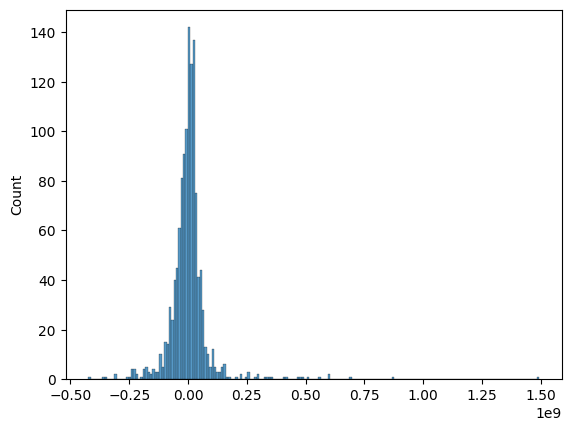

In [40]:
# first calculate residuals 
resid = y_test - test_preds

# Create a Q-QPlot
sns.histplot(resid);

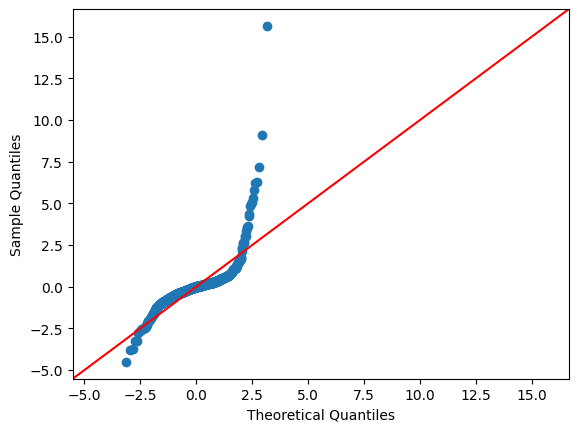

In [41]:
# then use sm's  qqplot
sm.graphics.qqplot(resid, line='45', fit=True);

### Residual Plot for Checking Homoscedasticity

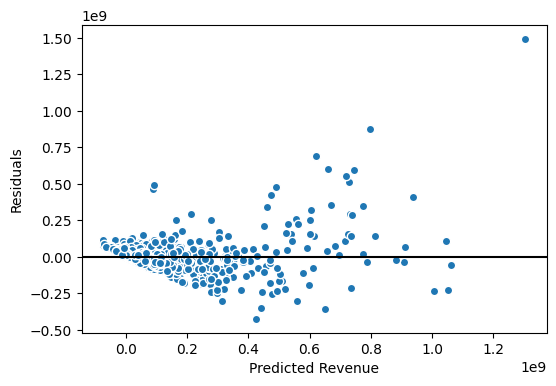

In [42]:
# Plot scatterplot with test_preds vs resids
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(test_preds, resid, ec='white')
ax.axhline(0, color='k')
ax.set(ylabel='Residuals',xlabel='Predicted Revenue');

In [43]:
# Lets put the above graphs into a function so we can reuse for later use
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression."""
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

### Checking our Coefficients


In [44]:
# extract the coefficients from model
# suppress scientific notation and add "," sep for 1,000's
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
result.params

certification_G                  19,157,588.60
certification_MISSING            15,140,875.20
certification_NC-17              20,002,578.46
certification_PG                 13,242,387.52
certification_PG-13              10,944,709.24
                                      ...     
ProdComp_Walt Disney Pictures    -1,794,327.35
ProdComp_Warner Bros. Pictures   -6,349,510.91
ProdComp_Wild Bunch              -1,193,357.01
ProdComp_Working Title Films     -2,795,415.45
const                            84,310,208.81
Length: 88, dtype: float64

# Improving Our Model
 ### Assumption of Linearity

Number of columns :  69


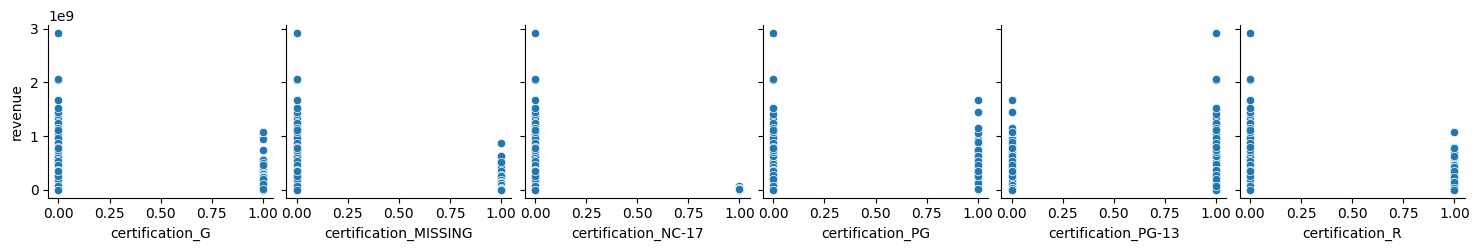

In [45]:
# concatenating training data into a dataframe that we will use for ploting
plot_df = pd.concat([X_train_df,y_train],axis=1)

# save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in df.columns if c.startswith('Genre')]
plot_cols = plot_df.drop(columns=['revenue',*genre_cols]).columns
print("Number of columns : ", len(plot_cols))

sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[:6]);

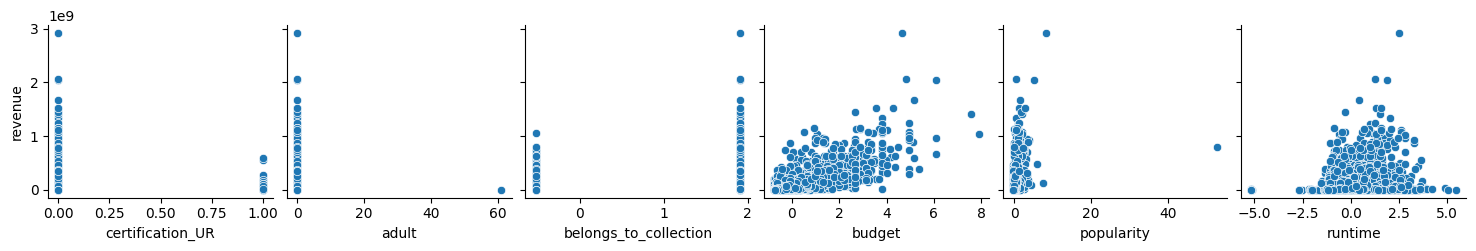

In [46]:
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[6:12]);

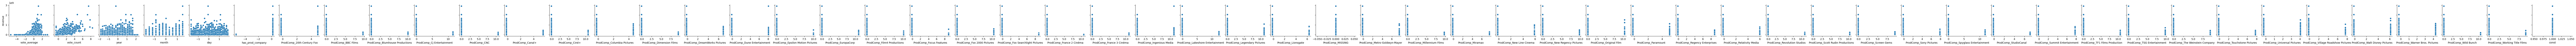

In [47]:
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[12:]); 

# Removing Outliers

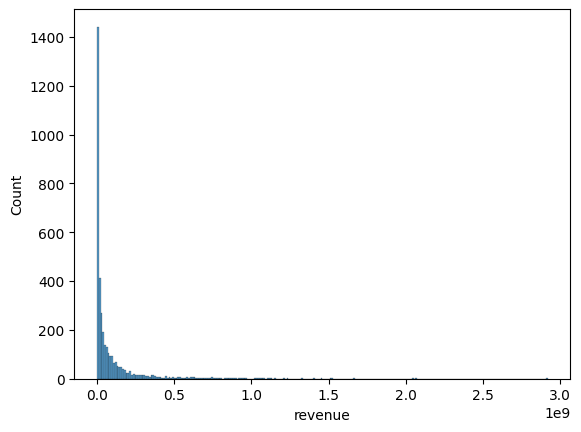

In [48]:
sns.histplot(plot_df['revenue']);

In [49]:
# Define a function that finds the outliers in a specific Series
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

In [50]:
# save a dictionary of the T/F outlier index for each feature in outleir_cols
outlier_cols = ['runtime','popularity','revenue']

outliers = {}
for col in outlier_cols:
    outliers_col = find_outliers(df[col])
    outliers[col] = outliers_col

- 64 outliers found in runtime using Z-Scores.
- 27 outliers found in popularity using Z-Scores.
- 127 outliers found in revenue using Z-Scores.


In [51]:
# Make new df_clean copy of df
df_clean = df.copy()

# loop through dictionary to remove outliers
for col, idx_outliers in outliers.items():
    df_clean = df_clean[~idx_outliers]
df_clean

C:\Users\default.DESKTOP-0LDO0LD\AppData\Local\Temp\ipykernel_1532\4144025219.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[~idx_outliers]


adult  belongs_to_collection         budget  popularity        revenue  \
4       0.00                  False     150,000.00       22.36  12,854,953.00   
11      0.00                  False     120,000.00        4.26      14,904.00   
13      0.00                   True  45,000,000.00       71.99 224,834,564.00   
16      0.00                  False   8,000,000.00       13.30     105,983.00   
17      0.00                   True 125,000,000.00       36.36 546,388,105.00   
...      ...                    ...            ...         ...            ...   
52607   0.00                   True   1,066,375.00        1.07   4,165,528.00   
52613   0.00                  False   8,120,000.00       17.75 124,652,206.00   
52636   0.00                  False   3,500,000.00        4.00  10,000,000.00   
52851   0.00                  False  12,547,000.00        3.33   1,091,477.00   
52977   0.00                  False     632,040.00        0.71      42,200.00   

       runtime  vote_average  vote_count certification  Genre_Comedy  ...  \
4        99.00          8.11    2,009.00            PG         False  ...   
11       87.00          5.40       42.00             R         False  ...   
13       84.00          6.70    4,158.00             G          True  ...   
16      122.00          5.90      254.00             R         False  ...   
17      123.00          6.10    5,508.00         PG-13         False  ...   
...        ...           ...         ...           ...           ...  ...   
52607   140.00          6.00        3.00           NaN         False  ...   
52613   111.00          7.08      176.00           NaN          True  ...   
52636   149.00          4.57        7.00           NaN          True  ...   
52851   116.00          6.82       11.00           NaN         False  ...   
52977   134.00          6.00        1.00           NaN         False  ...   

       ProdComp_TF1 Films Production  ProdComp_TSG Entertainment  \
4                              False                       False   
11                             False                       False   
13                             False                       False   
16                             False                       False   
17                             False                       False   
...                              ...                         ...   
52607                          False                       False   
52613                          False                       False   
52636                          False                       False   
52851                          False                       False   
52977                          False                       False   

       ProdComp_The Weinstein Company  ProdComp_Touchstone Pictures  \
4                               False                         False   
11                              False                         False   
13                              False                         False   
16                              False                         False   
17                              False                         False   
...                               ...                           ...   
52607                           False                         False   
52613                           False                         False   
52636                           False                         False   
52851                           False                         False   
52977                           False                         False   

       ProdComp_Universal Pictures  ProdComp_Village Roadshow Pictures  \
4                            False                               False   
11                           False                               False   
13                           False                               False   
16                           False                               False   
17                           False                               Fals

In [52]:
## REPEAT PREPROCESSING CODE
## Make x and y variables
y = df_clean['revenue']
X = df_clean.drop(columns=['revenue'])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train

# make X_train_df
preprocessor.fit(X_train)
final_features = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)

X_test_df = pd.DataFrame( preprocessor.transform(X_test), 
                         columns=final_features, index=X_test.index)

## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_df, has_constant='add')
X_test_df = sm.add_constant(X_test_df, has_constant='add')
display(X_test_df.head(), X_train_df.head())

const  certification_G  certification_MISSING  certification_NC-17  \
11812   1.00             1.00                   0.00                 0.00   
49557   1.00             0.00                   1.00                 0.00   
34084   1.00             0.00                   1.00                 0.00   
10217   1.00             0.00                   0.00                 0.00   
40682   1.00             0.00                   0.00                 0.00   

       certification_PG  certification_PG-13  certification_R  \
11812              0.00                 0.00             0.00   
49557              0.00                 0.00             0.00   
34084              0.00                 0.00             0.00   
10217              0.00                 1.00             0.00   
40682              0.00                 1.00             0.00   

       certification_UR  adult  budget  ...  ProdComp_TF1 Films Production  \
11812              0.00  -0.02    0.24  ...                           0.00   
49557              0.00  -0.02   -0.75  ...                           0.00   
34084              0.00  -0.02   -0.79  ...                           0.00   
10217              0.00  -0.02   -0.24  ...                           0.00   
40682              0.00  -0.02   -0.51  ...                           0.00   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
11812                        0.00                            0.00   
49557                        0.00                            0.00   
34084                        0.00                            0.00   
10217                        0.00                            0.00   
40682                        0.00                            0.00   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
11812                          0.00                         0.00   
49557                          0.00                         0.00   
34084                          0.00                         0.00   
10217                          0.00                         0.00   
40682                          0.00                         0.00   

       ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
11812                                0.00                           0.00   
49557                                0.00                           0.00   
34084                                0.00                           0.00   
10217                                0.00                           0.00   
40682                                0.00                           0.00   

       ProdComp_Warner Bros. Pictures  ProdComp_Wild Bunch  \
11812                            0.00                 0.00   
49557                            0.00                 0.00   
34084                            0.00                 0.00   
10217                            0.00                 0.00   
40682                            0.00                 0.00   

       ProdComp_Working Title Films  
11812                          0.00  
49557                          0.00  
34084                          0.00  
10217                          0.00  
40682                          0.00  

[5 rows x 88 columns]

const  certification_G  certification_MISSING  certification_NC-17  \
41226   1.00             0.00                   1.00                 0.00   
8381    1.00             0.00                   0.00                 0.00   
12331   1.00             1.00                   0.00                 0.00   
38207   1.00             0.00                   1.00                 0.00   
39593   1.00             0.00                   0.00                 0.00   

       certification_PG  certification_PG-13  certification_R  \
41226              0.00                 0.00             0.00   
8381               0.00                 0.00             1.00   
12331              0.00                 0.00             0.00   
38207              0.00                 0.00             0.00   
39593              0.00                 1.00             0.00   

       certification_UR  adult  budget  ...  ProdComp_TF1 Films Production  \
41226              0.00  -0.02   -0.68  ...                           0.00   
8381               0.00  -0.02   -0.43  ...                           0.00   
12331              0.00  -0.02   -0.10  ...                           0.00   
38207              0.00  -0.02   -0.79  ...                           0.00   
39593              0.00  -0.02   -0.26  ...                           0.00   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
41226                        0.00                            0.00   
8381                         0.00                            0.00   
12331                        0.00                            0.00   
38207                        0.00                            0.00   
39593                        0.00                            0.00   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
41226                          0.00                         0.00   
8381                           0.00                         0.00   
12331                          0.00                         0.00   
38207                          0.00                         0.00   
39593                          0.00                         0.00   

       ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
41226                                0.00                           0.00   
8381                                 0.00                           0.00   
12331                                0.00                           1.00   
38207                                0.00                           0.00   
39593                                0.00                           0.00   

       ProdComp_Warner Bros. Pictures  ProdComp_Wild Bunch  \
41226                            0.00                 0.00   
8381                             0.00                 0.00   
12331                            0.00                 0.00   
38207                            0.00                 0.00   
39593                            0.00                 0.00   

       ProdComp_Working Title Films  
41226                          0.00  
8381                           0.00  
12331                          0.00  
38207                          0.00  
39593                          0.00  

[5 rows x 88 columns]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     158.1
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:05:53   Log-Likelihood:                -68431.
No. Observations:                3575   AIC:                         1.370e+05
Df Residuals:                    3490   BIC:                         1.376e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               6.294e+07   5.29e+06     11.888      0.000    5.26e+07    7.33e+07
certification_G                     9.877e+06   7.06e+06      1.400      0.162   -3.96e+06    2.37e+07
certification_MISSING               1.152e+07   2.88e+06      3.999      0.000    5.87e+06    1.72e+07
certification_NC-17                 1.407e+07   1.35e+07      1.041      0.298   -1.24e+07    4.05e+07
certification_PG                    1.694e+07   3.83e+06      4.420      0.000    9.42e+06    2.45e+07
certification_PG-13                 7.063e+06   2.99e+06      2.360      0.018    1.19e+06    1.29e+07
certification_R                    -5.526e+06   2.88e+06     -1.919      0.055   -1.12e+07     1.2e+05
certification_UR                    8.994e+06   4.86e+06      1.852      0.064   -5.26e+05    1.85e+07
adult                              -2.799e+04   8.45e+05     -0.033      0.974   -1.68e+06    1.63e+06
budget                               4.98e+07   1.37e+06     36.474      0.000    4.71e+07    5.25e+07
popularity                          7.251e+06   1.22e+06      5.922      0.000    4.85e+06    9.65e+06
runtime                             1.655e+06   1.03e+06      1.612      0.107   -3.58e+05    3.67e+06
vote_average                       -7.135e+04   9.97e+05     -0.072      0.943   -2.03e+06    1.88e+06
vote_count                          4.989e+07   1.29e+06     38.666      0.000    4.74e+07    5.24e+07
year                               -3.302e+05   9.39e+05     -0.352      0.725   -2.17e+06    1.51e+06
month                               2.036e+05    8.6e+05      0.237      0.813   -1.48e+06    1.89e+06
day                                -2.269e+05   8.53e+05     -0.266      0.790    -1.9e+06    1.45e+06
belongs_to_collection               3.606e+07   2.36e+06     15.300      0.000    3.14e+07    4.07e+07
Genre_Comedy                        8.439e+06    2.2e+06      3.831      0.000    4.12e+06    1.28e+07
Genre_Music                         1.241e+07    5.4e+06      2.297      0.022    1.82e+06     2.3e+07
Genre_Romance                       6.508e+06   2.47e+06      2.635      0.008    1.67e+06    1.14e+07
Genre_Science Fiction              -2.822e+07    3.3e+06     -8.556      0.000   -3.47e+07   -2.18e+07
Genre_Drama                        -1.596e+06   2.22e+06     -0.718      0.473   -5.95e+06    2.76e+06
Genre_Action                       -2.872e+06   2.38e+06     -1.208      0.227   -7.53e+06    1.79e+06
Genre_Crime                        -5.601e+06   2.66e+06     -2.108      0.035   -1.08e+07   -3.91e+05
Genre_Adventure                    -2.842e+06   2.87e+06     -0.990      0.322   -8.47e+06    2.79e+06
Genre_Animation                     1.907e+07   4.66e+06      4.091      0.000    9.93e+06    2.

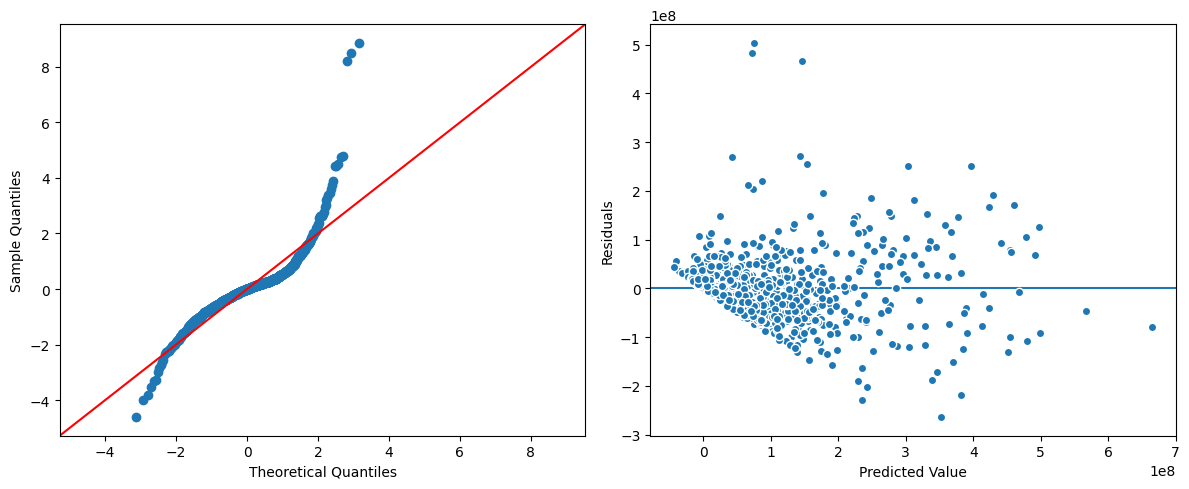

In [53]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result,X_test_df,y_test)

result.summary()

# Addressing Multicollinearity

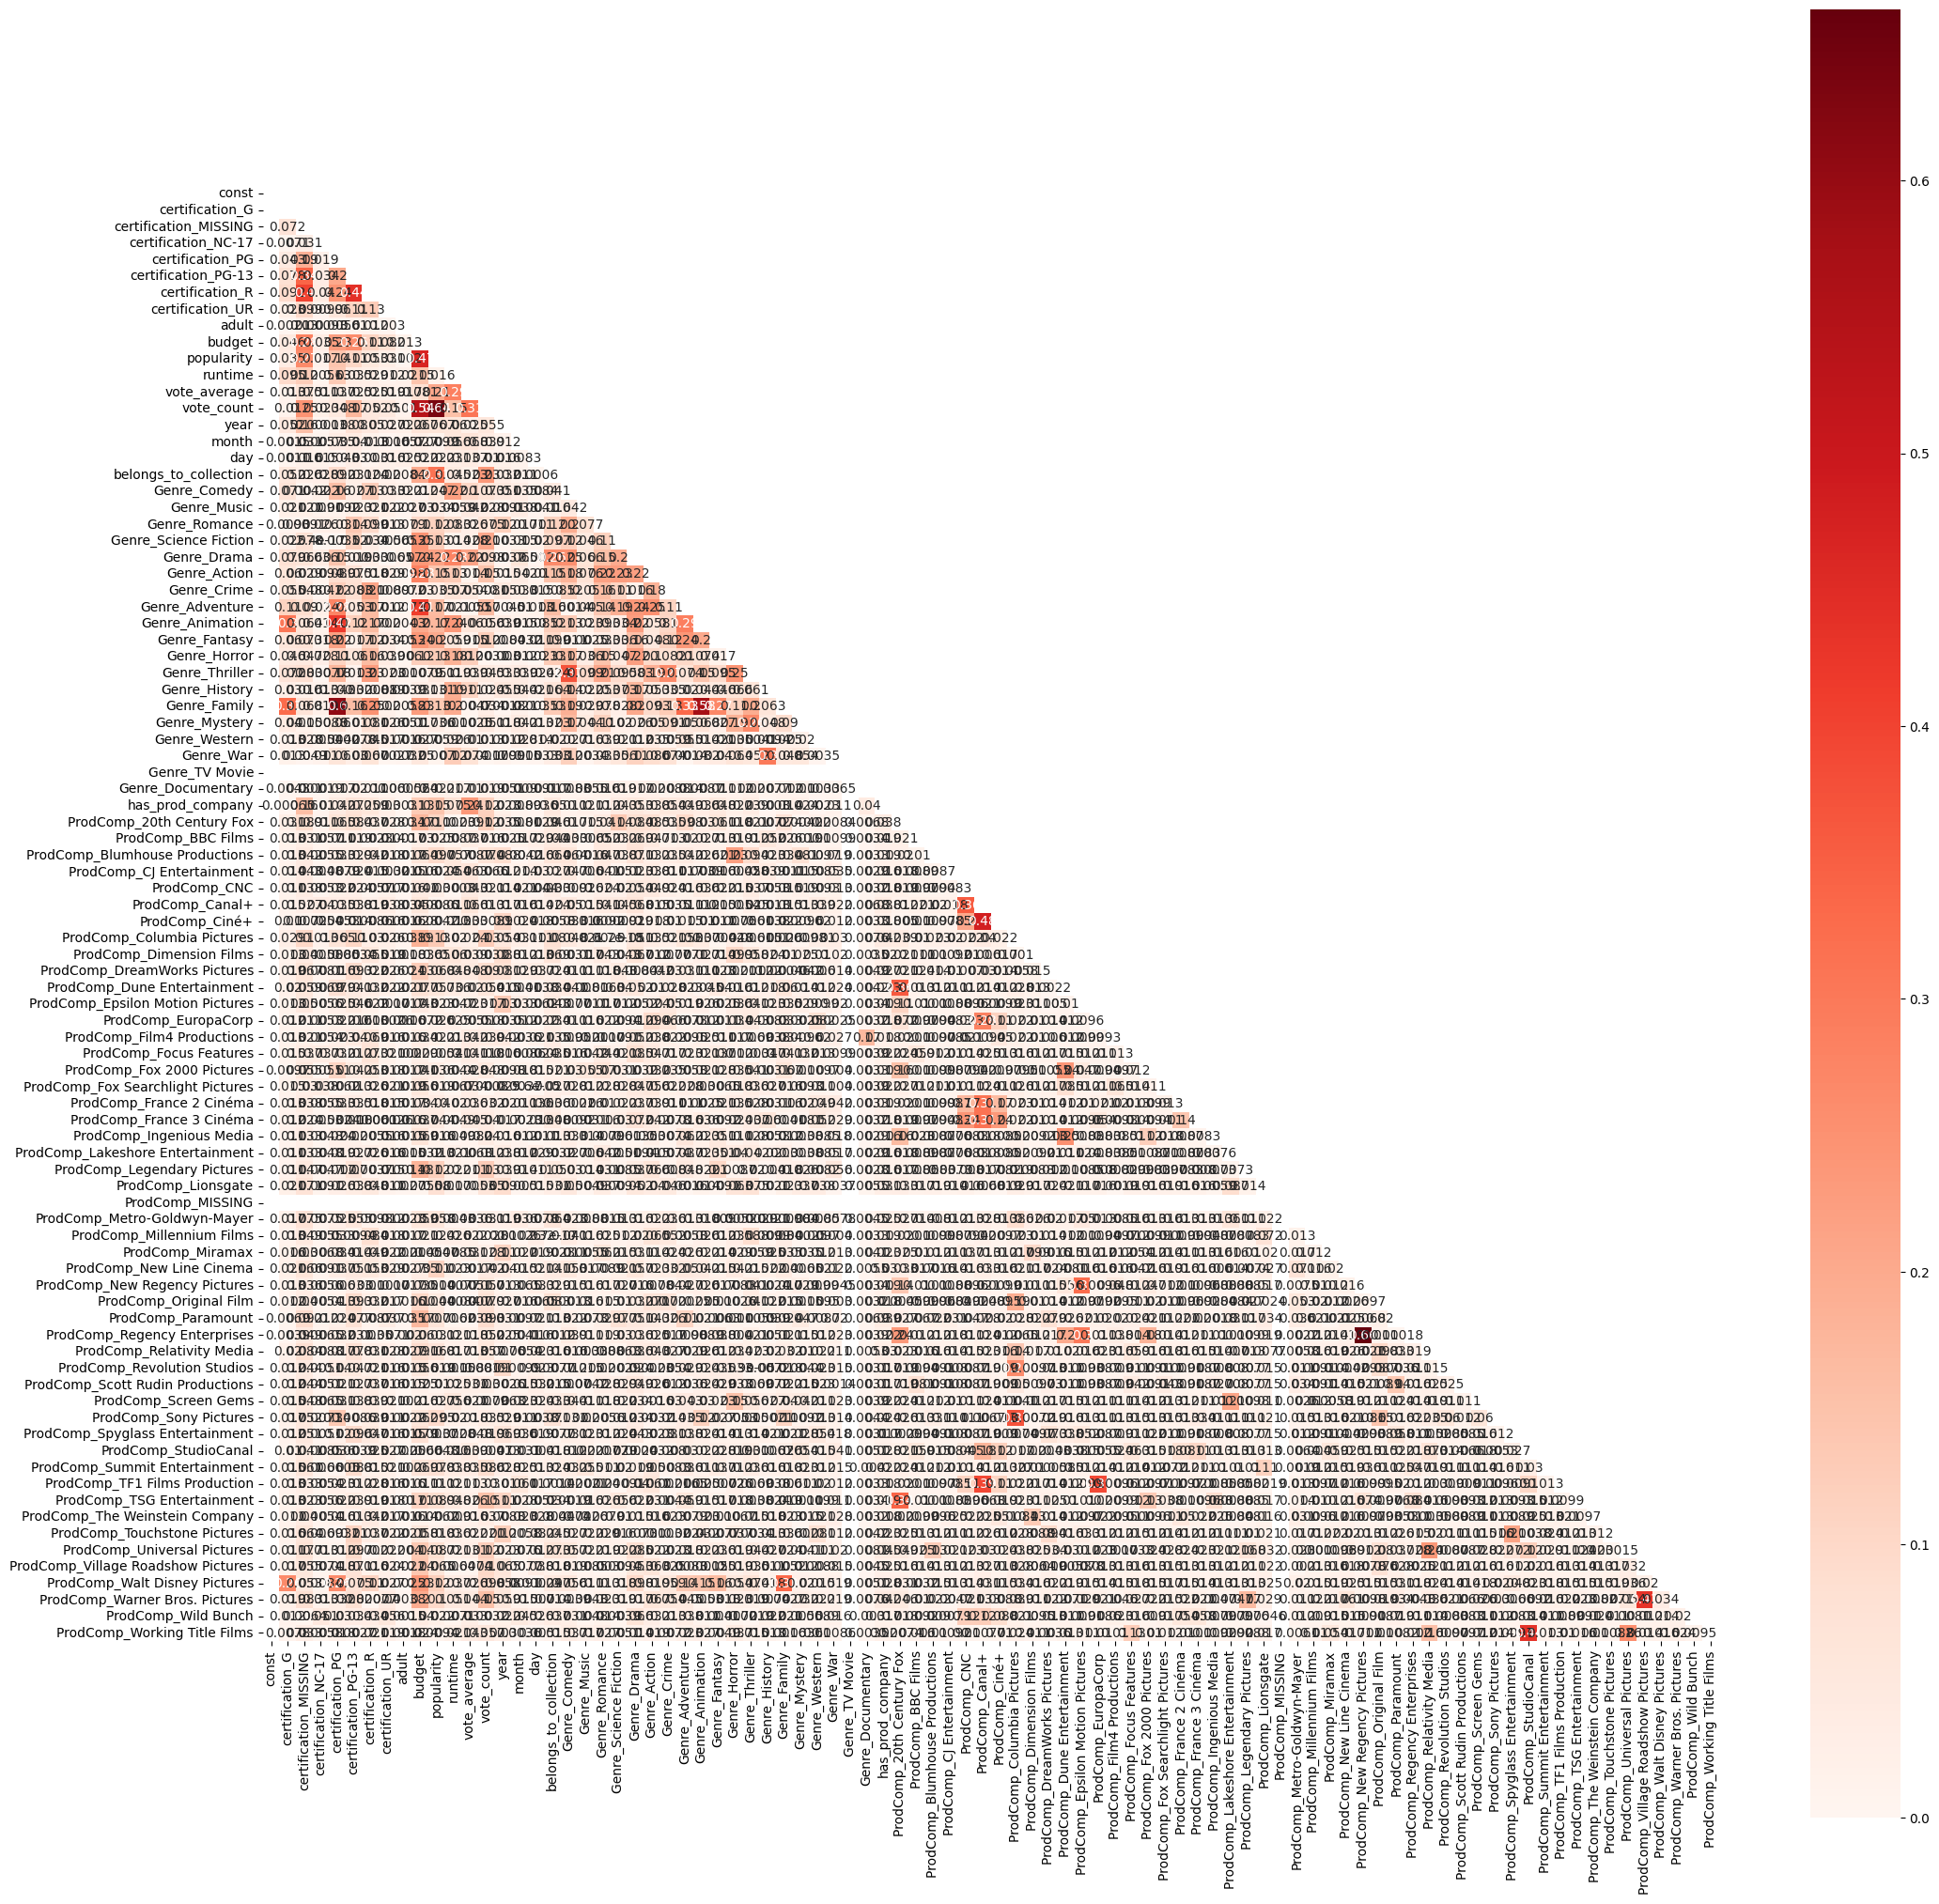

In [54]:
# Calculating the mask to hide the upper-right of the triangle
plt.figure(figsize=(25,25))
corr = X_train_df.corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);

Because there are no correlations greater or less then 8.0 and -8.0 we don't need to change anything. However, if two features were strongly correlated we would need to drop one of them before continuing with our final model.

# Variance Inflation Factor

In [55]:
# separate just x-data and subtract mean
features = X_train_df - X_train_df.mean()

# create a list of VIF scores for each feature in features.
vif_scores = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

# create a new dataframe to hold the VIF scores 
VIF = pd.Series(vif_scores, index=features.columns)

# Sort VIF for inspection
print("Sorted VIF WITH infinite values\n", VIF.sort_values())

## remove infinite values from VIF and sort
VIF = VIF[VIF!=np.inf].sort_values()
print("\n\nSorted VIF WITHOUT infinite values\n", VIF)

C:\Users\default.DESKTOP-0LDO0LD\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\default.DESKTOP-0LDO0LD\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Sorted VIF WITH infinite values
 adult                       1.01
ProdComp_CJ Entertainment   1.03
day                         1.03
Genre_Documentary           1.04
ProdComp_BBC Films          1.04
                            ... 
certification_MISSING        inf
certification_G              inf
const                        NaN
Genre_TV Movie               NaN
ProdComp_MISSING             NaN
Length: 88, dtype: float64


Sorted VIF WITHOUT infinite values
 adult                       1.01
ProdComp_CJ Entertainment   1.03
day                         1.03
Genre_Documentary           1.04
ProdComp_BBC Films          1.04
                            ... 
Genre_Family                2.48
budget                      2.63
const                        NaN
Genre_TV Movie               NaN
ProdComp_MISSING             NaN
Length: 81, dtype: float64


In [56]:
## filter for VIF that are > 5
VIF[VIF>5]

high_vif = VIF[VIF>5].index
high_vif

Index([], dtype='object')

# Final Model

In [57]:
df_final = df_clean.drop(columns='certification')
df_final

adult  belongs_to_collection         budget  popularity        revenue  \
4       0.00                  False     150,000.00       22.36  12,854,953.00   
11      0.00                  False     120,000.00        4.26      14,904.00   
13      0.00                   True  45,000,000.00       71.99 224,834,564.00   
16      0.00                  False   8,000,000.00       13.30     105,983.00   
17      0.00                   True 125,000,000.00       36.36 546,388,105.00   
...      ...                    ...            ...         ...            ...   
52607   0.00                   True   1,066,375.00        1.07   4,165,528.00   
52613   0.00                  False   8,120,000.00       17.75 124,652,206.00   
52636   0.00                  False   3,500,000.00        4.00  10,000,000.00   
52851   0.00                  False  12,547,000.00        3.33   1,091,477.00   
52977   0.00                  False     632,040.00        0.71      42,200.00   

       runtime  vote_average  vote_count  Genre_Comedy  Genre_Music  ...  \
4        99.00          8.11    2,009.00         False        False  ...   
11       87.00          5.40       42.00         False        False  ...   
13       84.00          6.70    4,158.00          True        False  ...   
16      122.00          5.90      254.00         False        False  ...   
17      123.00          6.10    5,508.00         False        False  ...   
...        ...           ...         ...           ...          ...  ...   
52607   140.00          6.00        3.00         False        False  ...   
52613   111.00          7.08      176.00          True        False  ...   
52636   149.00          4.57        7.00          True        False  ...   
52851   116.00          6.82       11.00         False        False  ...   
52977   134.00          6.00        1.00         False        False  ...   

       ProdComp_TF1 Films Production  ProdComp_TSG Entertainment  \
4                              False                       False   
11                             False                       False   
13                             False                       False   
16                             False                       False   
17                             False                       False   
...                              ...                         ...   
52607                          False                       False   
52613                          False                       False   
52636                          False                       False   
52851                          False                       False   
52977                          False                       False   

       ProdComp_The Weinstein Company  ProdComp_Touchstone Pictures  \
4                               False                         False   
11                              False                         False   
13                              False                         False   
16                              False                         False   
17                              False                         False   
...                               ...                           ...   
52607                           False                         False   
52613                           False                         False   
52636                           False                         False   
52851                           False                         False   
52977                           False                         False   

       ProdComp_Universal Pictures  ProdComp_Village Roadshow Pictures  \
4                            False                               False   
11                           False                               False   
13                           False                               False   
16                           False                               False   
17                           False                               False   
...    

In [58]:
# Make x and y variables
y = df_final['revenue']
X = df_final.drop(columns=['revenue'])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train

# make X_train_df
preprocessor.fit(X_train)
final_features = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame( preprocessor.transform(X_train), columns=final_features, index=X_train.index)

X_test_df = pd.DataFrame( preprocessor.transform(X_test), columns=final_features, index=X_test.index)

## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_df, has_constant='add')
X_test_df = sm.add_constant(X_test_df, has_constant='add')
display(X_test_df.head(), X_train_df.head())

const  adult  budget  popularity  runtime  vote_average  vote_count  \
11812   1.00  -0.02    0.24       -0.39    -1.47         -1.26       -0.51   
49557   1.00  -0.02   -0.75       -0.74    -0.67          1.75       -0.61   
34084   1.00  -0.02   -0.79       -0.66    -1.96          0.22       -0.61   
10217   1.00  -0.02   -0.24        0.03    -0.19          0.38        0.52   
40682   1.00  -0.02   -0.51        0.08    -0.67          0.90        0.70   

       year  month   day  ...  ProdComp_TF1 Films Production  \
11812 -0.38  -0.24  1.13  ...                           0.00   
49557  1.63   1.51  1.36  ...                           0.00   
34084  1.08  -1.70  0.78  ...                           0.00   
10217 -0.56  -0.83 -0.39  ...                           0.00   
40682  1.27  -0.53  0.31  ...                           0.00   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
11812                        0.00                            0.00   
49557                        0.00                            0.00   
34084                        0.00                            0.00   
10217                        0.00                            0.00   
40682                        0.00                            0.00   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
11812                          0.00                         0.00   
49557                          0.00                         0.00   
34084                          0.00                         0.00   
10217                          0.00                         0.00   
40682                          0.00                         0.00   

       ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
11812                                0.00                           0.00   
49557                                0.00                           0.00   
34084                                0.00                           0.00   
10217                                0.00                           0.00   
40682                                0.00                           0.00   

       ProdComp_Warner Bros. Pictures  ProdComp_Wild Bunch  \
11812                            0.00                 0.00   
49557                            0.00                 0.00   
34084                            0.00                 0.00   
10217                            0.00                 0.00   
40682                            0.00                 0.00   

       ProdComp_Working Title Films  
11812                          0.00  
49557                          0.00  
34084                          0.00  
10217                          0.00  
40682                          0.00  

[5 rows x 81 columns]

const  adult  budget  popularity  runtime  vote_average  vote_count  \
41226   1.00  -0.02   -0.68       -0.45    -0.99         -0.14       -0.59   
8381    1.00  -0.02   -0.43       -0.32     0.67          1.10       -0.11   
12331   1.00  -0.02   -0.10       -0.55    -1.37         -0.63       -0.52   
38207   1.00  -0.02   -0.79       -0.79     1.95          0.98       -0.64   
39593   1.00  -0.02   -0.26       -0.16     0.13         -0.50        0.14   

       year  month   day  ...  ProdComp_TF1 Films Production  \
41226  1.27  -1.70  0.43  ...                           0.00   
8381  -0.75  -1.12  0.19  ...                           0.00   
12331 -0.38  -1.12 -0.97  ...                           0.00   
38207  1.08  -0.83 -0.86  ...                           0.00   
39593  1.27   0.63  1.48  ...                           0.00   

       ProdComp_TSG Entertainment  ProdComp_The Weinstein Company  \
41226                        0.00                            0.00   
8381                         0.00                            0.00   
12331                        0.00                            0.00   
38207                        0.00                            0.00   
39593                        0.00                            0.00   

       ProdComp_Touchstone Pictures  ProdComp_Universal Pictures  \
41226                          0.00                         0.00   
8381                           0.00                         0.00   
12331                          0.00                         0.00   
38207                          0.00                         0.00   
39593                          0.00                         0.00   

       ProdComp_Village Roadshow Pictures  ProdComp_Walt Disney Pictures  \
41226                                0.00                           0.00   
8381                                 0.00                           0.00   
12331                                0.00                           1.00   
38207                                0.00                           0.00   
39593                                0.00                           0.00   

       ProdComp_Warner Bros. Pictures  ProdComp_Wild Bunch  \
41226                            0.00                 0.00   
8381                             0.00                 0.00   
12331                            0.00                 0.00   
38207                            0.00                 0.00   
39593                            0.00                 0.00   

       ProdComp_Working Title Films  
41226                          0.00  
8381                           0.00  
12331                          0.00  
38207                          0.00  
39593                          0.00  

[5 rows x 81 columns]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     166.6
Date:                Tue, 22 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:06:31   Log-Likelihood:                -68464.
No. Observations:                3575   AIC:                         1.371e+05
Df Residuals:                    3496   BIC:                         1.376e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               7.034e+07   5.44e+06     12.925      0.000    5.97e+07     8.1e+07
adult                               1.036e+05   8.51e+05      0.122      0.903   -1.56e+06    1.77e+06
budget                              5.012e+07   1.34e+06     37.312      0.000    4.75e+07    5.28e+07
popularity                            6.7e+06   1.23e+06      5.457      0.000    4.29e+06    9.11e+06
runtime                             2.364e+06   1.02e+06      2.323      0.020    3.68e+05    4.36e+06
vote_average                        -3.45e+04      1e+06     -0.034      0.973      -2e+06    1.93e+06
vote_count                            4.9e+07   1.29e+06     37.867      0.000    4.65e+07    5.15e+07
year                                2.792e+05   9.37e+05      0.298      0.766   -1.56e+06    2.12e+06
month                               3.459e+05   8.66e+05      0.400      0.690   -1.35e+06    2.04e+06
day                                -2.273e+05    8.6e+05     -0.264      0.792   -1.91e+06    1.46e+06
belongs_to_collection               3.694e+07   2.36e+06     15.629      0.000    3.23e+07    4.16e+07
Genre_Comedy                        8.543e+06   2.22e+06      3.851      0.000    4.19e+06    1.29e+07
Genre_Music                         1.134e+07   5.44e+06      2.085      0.037    6.76e+05     2.2e+07
Genre_Romance                       7.255e+06   2.47e+06      2.936      0.003    2.41e+06    1.21e+07
Genre_Science Fiction              -2.789e+07   3.32e+06     -8.400      0.000   -3.44e+07   -2.14e+07
Genre_Drama                        -1.867e+06   2.23e+06     -0.836      0.403   -6.25e+06    2.51e+06
Genre_Action                       -2.926e+06   2.39e+06     -1.226      0.220   -7.61e+06    1.76e+06
Genre_Crime                        -8.502e+06   2.65e+06     -3.210      0.001   -1.37e+07   -3.31e+06
Genre_Adventure                    -1.514e+06   2.88e+06     -0.525      0.600   -7.17e+06    4.14e+06
Genre_Animation                     2.116e+07   4.58e+06      4.619      0.000    1.22e+07    3.01e+07
Genre_Fantasy                      -1.094e+07   3.26e+06     -3.357      0.001   -1.73e+07   -4.55e+06
Genre_Horror                       -2.168e+06   3.28e+06     -0.661      0.509    -8.6e+06    4.27e+06
Genre_Thriller                      1.154e+06   2.35e+06      0.492      0.623   -3.45e+06    5.76e+06
Genre_History                      -1.202e+06   4.26e+06     -0.282      0.778   -9.55e+06    7.14e+06
Genre_Family                        5.307e+06   3.82e+06      1.390      0.165   -2.18e+06    1.28e+07
Genre_Mystery                      -4.642e+06   3.24e+06     -1.432      0.152    -1.1e+07    1.71e+06
Genre_Western                      -2.241e+07   8.94e+06     -2.506      0.012   -3.99e+07   -4.

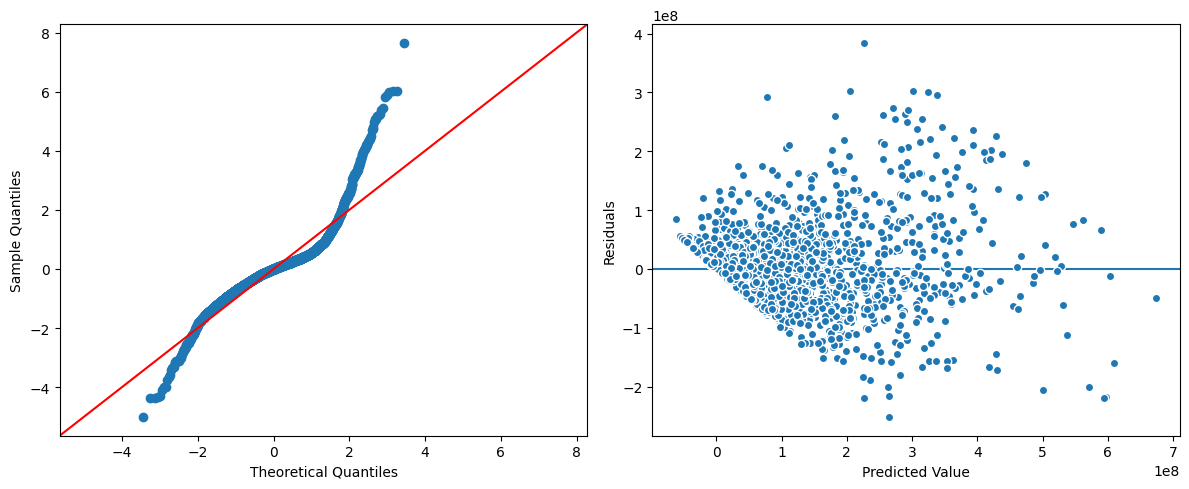

In [59]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result,X_train_df,y_train)

result.summary()

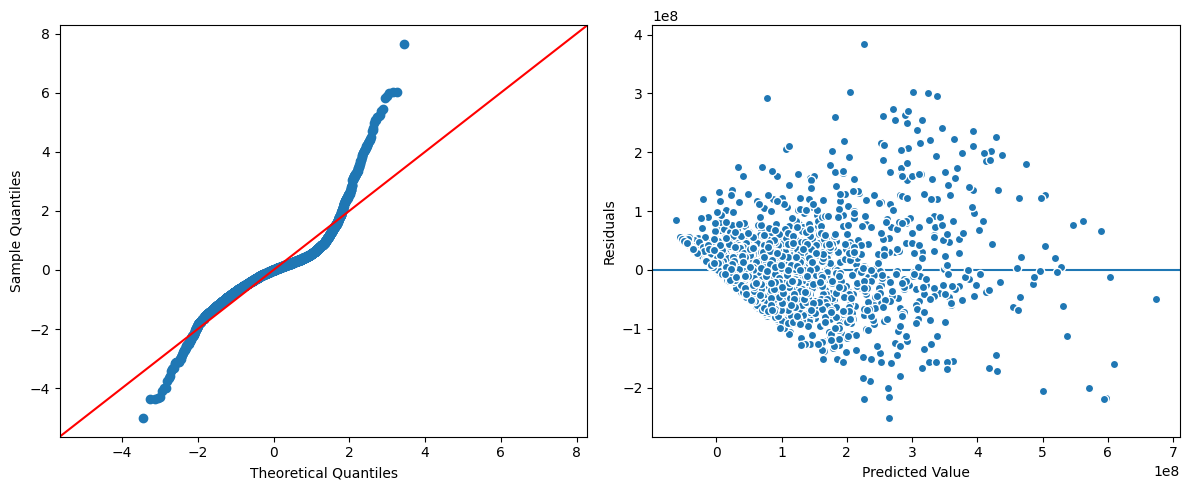

In [60]:
evaluate_ols(result,X_train_df,y_train)
plt.tight_layout()
plt.savefig('Visuals/final_model_graphs.png', pad_inches=1)

C:\Users\default.DESKTOP-0LDO0LD\AppData\Local\Temp\ipykernel_1532\1425447999.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


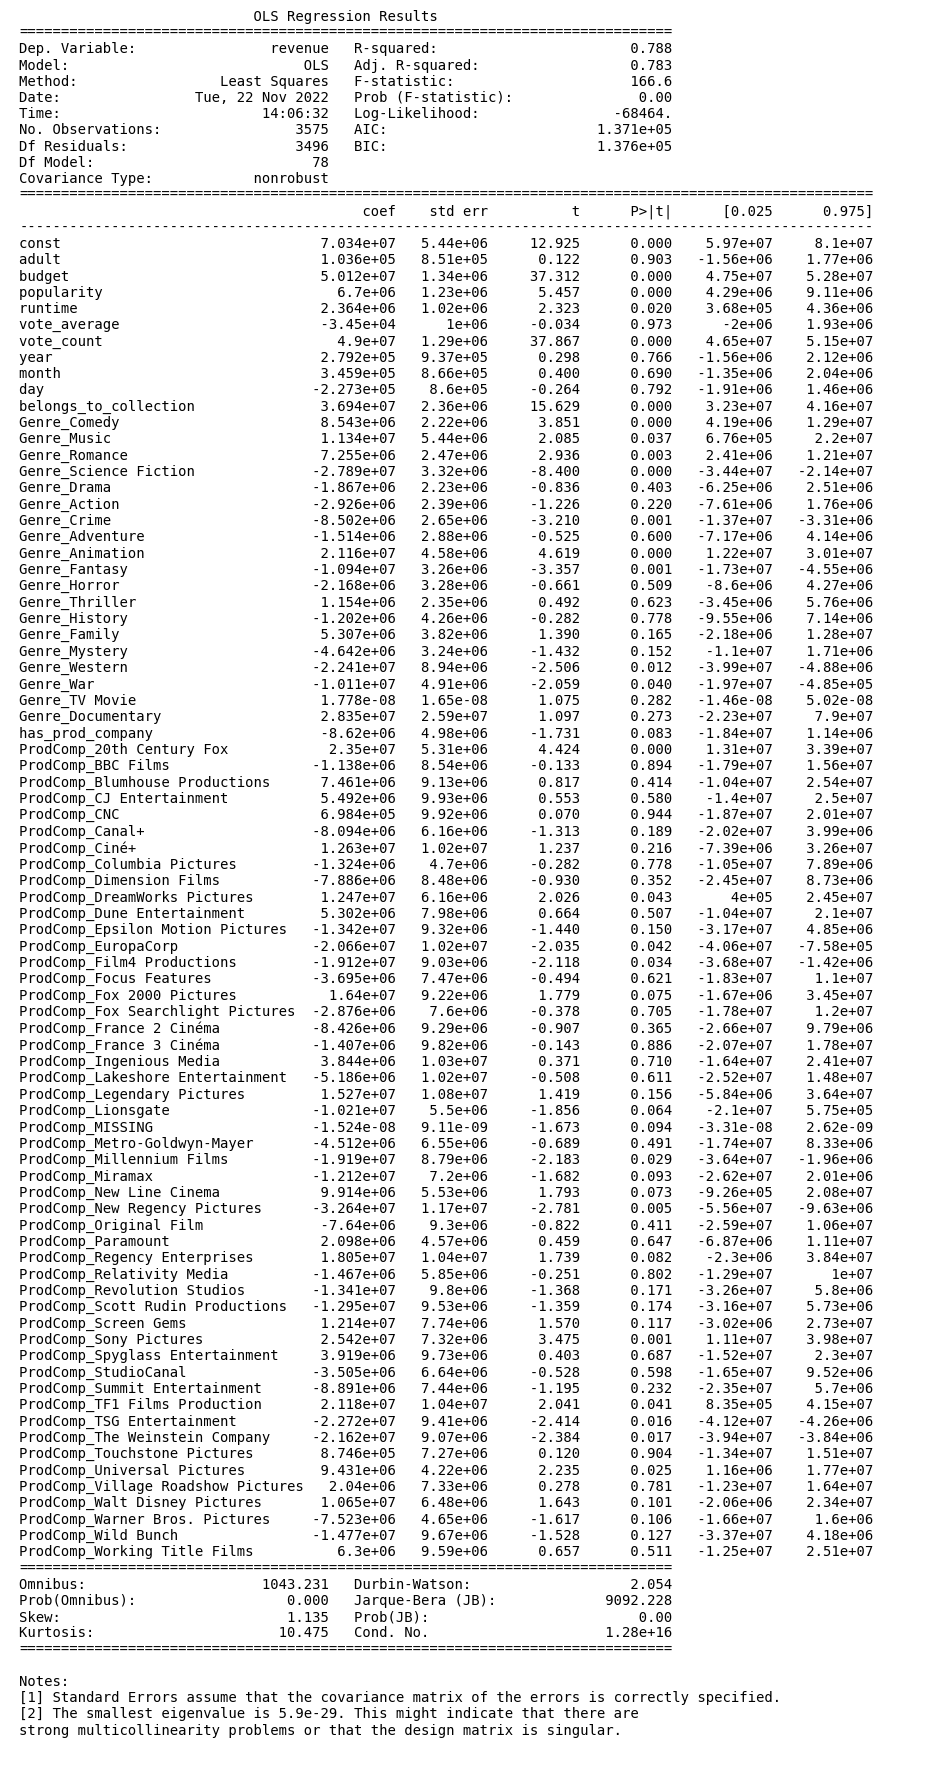

In [61]:
# save results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('Visuals/final_model_results.png')

In [62]:
# Getting the testing scores

# store test predictions 
test_preds = result.predict(X_test_df)

test_r2 = r2_score(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'For testing data:\nr-square : is {test_r2.round(3)} \nMean Squared Error(MSE) : {test_mse.round(3):e}.')

For testing data:
r-square : is 0.729 
Mean Squared Error(MSE) : 3.271517e+15.


In [63]:
result.params

const                                 70,339,536.76
adult                                    103,554.47
budget                                50,124,333.73
popularity                             6,700,304.49
runtime                                2,363,963.13
                                          ...      
ProdComp_Village Roadshow Pictures     2,040,312.68
ProdComp_Walt Disney Pictures         10,645,422.76
ProdComp_Warner Bros. Pictures        -7,522,728.05
ProdComp_Wild Bunch                  -14,771,824.67
ProdComp_Working Title Films           6,300,082.26
Length: 81, dtype: float64